In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing as pre

from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import pairwise_distances, accuracy_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

from tqdm import tqdm

In [2]:
# load
data_path = pathlib.Path().joinpath('data', 'data.csv')
data = pd.read_csv(data_path, index_col='id')

# int as dummies
# int_columns = data.columns[data.dtypes == int]
# dummies = pd.get_dummies(data[int_columns].astype('category'))
# data = pd.concat([data.drop(int_columns, axis=1), dummies], axis=1)

# PowerTransform int
# int_columns = data.columns[data.dtypes == int]
# data[int_columns] = pre.power_transform(data[int_columns])

# prepare data
scaled = make_pipeline(
    pre.PowerTransformer(),
    # pre.MaxAbsScaler(),
).fit_transform(data)

# select columns
col_names = [f'f_{n:02d}' for n in (*range(7, 14), *range(22, 29))]
usecols = np.arange(data.shape[1])[data.columns.isin(col_names)]
selected = scaled[:, usecols]
# others = np.arange(data.shape[1])[~data.columns.isin(col_names)]
# leftcols = scaled[:, others]

In [11]:
def multiple_clustering(X, *, iters=3, subsample=1, threshold=0.8, folds=5, seed=None, **kwargs):
    assert (subsample > 0) and (subsample <=1), f"Subsample must be > 0 and <= 1"
    n_clusters = kwargs.get('n_clusters', 5)
    n_init = kwargs.get('n_init', 1)
    tol = kwargs.get('tol', 1e-3)
    np.random.seed(seed)

    basic_means = None
    subsize = np.ceil(X.shape[0] * subsample).astype(int)
    proba = np.zeros((X.shape[0], n_clusters))
    score = np.zeros((X.shape[0], n_clusters))
    label = []
    pbar = tqdm(range(iters), desc='fit', total=iters)
    for i in pbar:
        # choose subsample        
        sample = np.random.choice(X.shape[0], subsize, replace=X.shape[0] <= subsize)
        # fit BGM
        bgm = BayesianGaussianMixture(n_components=n_clusters, n_init=n_init, tol=tol, random_state=np.random.randint(2 ** 16)).fit(X[sample])
        if i == 0:
            basic_means = bgm.means_
        p = bgm.predict_proba(X)
        lb = p.argmax(axis=1)

        # boost BGM
        bundle = [
            LGBMClassifier(random_state=np.random.randint(2**16), n_jobs=-1, n_estimators=500),
            ExtraTreesClassifier(random_state=np.random.randint(2**16), n_jobs=-1),
            # LinearDiscriminantAnalysis(),
        ]
        # estimator = LGBMClassifier(random_state=np.random.randint(2**16), n_jobs=-1)
        # estimator = LinearDiscriminantAnalysis()

        trusted = p.max(axis=1) > threshold
        trusted_proba = np.zeros_like(p)
        if folds > 1:
            estimator = np.random.choice(bundle)
            kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=np.random.randint(2 ** 16))        
            for train, valid in kf.split(X[trusted], lb[trusted]):
                estimator.fit(X[trusted][train], lb[trusted][train])
                trusted_proba += estimator.predict_proba(X)
        else:
            estimator = np.random.choice(bundle)
            estimator.fit(X[trusted], lb[trusted])
            trusted_proba += estimator.predict_proba(X)
        # refresh proba
        p = trusted_proba

        # calc current clusters distances with the first set of clusters
        dist = pairwise_distances(basic_means, bgm.means_, metric='euclidean')
        # match current clusters with basic
        order = dist.argmin(axis=1)
        proba += p[:, order]
        # calc cluster scores
        weights = 1 / (1 + dist ** 2)
        score += p @ weights.T      # this approach takes into account the similarity with other basic clusters more strongly than proba sum
        # calc cluster remapped labels
        label.append(p[:, order].argmax(axis=1))

    # calc labels count
    bundle = np.c_[label].T
    counter = np.apply_along_axis(lambda row: dict(zip(*np.unique(row, return_counts=True))), 1, bundle)
    count = pd.DataFrame(list(counter)).fillna(0)[range(n_clusters)].values.astype(int)
    
    return proba, count, score

In [12]:
# Kaggle ???
n_clusters = 7
scr, cnt, prb = multiple_clustering(selected, iters=20, n_clusters=n_clusters, n_init=3, tol=1e-2,
                                    subsample=0.7, threshold=0.8, folds=5, seed=17)
labels = scr.argmax(axis=1)

fit: 100%|██████████| 20/20 [24:14<00:00, 72.75s/it] 


In [13]:
print(f'Silhouette: {silhouette_score(selected, labels)}',
      f'Davies bouldin: {davies_bouldin_score(selected, labels)}', sep='\n')

Silhouette: 0.03947593156450084
Davies bouldin: 3.531571170586145


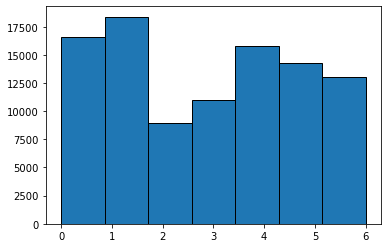

In [14]:
# clusters distribution
plt.hist(labels, edgecolor='black', bins=np.unique(labels).size)
plt.show()

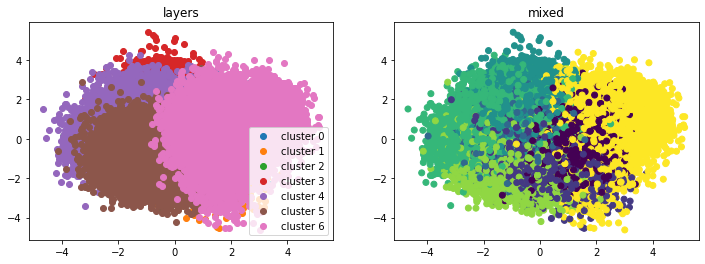

In [15]:
# plot
_, ax = plt.subplots(1, 2, figsize=(12, 4))
X2d = PCA(2, random_state=11).fit_transform(scaled)
ax[0].set_title('layers')
for lb in np.unique(labels):
    idx = labels == lb
    ax[0].scatter(X2d.T[0][idx], X2d.T[1][idx], label=f'cluster {lb}',)
ax[0].legend()
ax[1].set_title('mixed')
ax[1].scatter(X2d.T[0], X2d.T[1], c=labels);

In [16]:
# save submission
sub_path = pathlib.Path().joinpath('data', 'sample_submission.csv')
sub = pd.read_csv(sub_path)
sub['Predicted'] = labels
sub.to_csv('submission.csv', index=False)
sub

,Id,Predicted
0,0,5
1,1,2
2,2,5
3,3,6
4,4,1
...,...,...
97995,97995,0
97996,97996,4
97997,97997,0
97998,97998,3


In [17]:
#